# Quickstart: Building a GenAI powered Semantic Data Model with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic model. The semantic model captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is a Semantic Model?**

A semantic model is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

*   **Generate Semantic Model** → The unified layer that transforms fragmented datasets, creating the foundation for connected intelligence.
    *   **1.1 Profile and classify data** → Analyze your data sources to understand their structure, data types, and other characteristics.
    *   **1.2 Discover links & relationships among data** → Reveal meaningful connections (PK & FK) across fragmented tables.
    *   **1.3 Generate a business glossary** → Create business-friendly terms and use them to query data with context.
    *   **1.4 Enable Semantic search** → Intelligent search that understands meaning, not just keywords—making data more accessible across both technical and business users.
    *   **1.5 Visualize semantic model** → Get access to enriched metadata of the semantic model and visualize your data and relationships.
*   **Build Unified Data Products** → Simply pick the attributes across your data tables, and let the toolkit auto-generate queries with all the required joins, transformations, and aggregations using the semantic layer. When executed, these queries produce reusable data products.

Before you start, make sure you install the **Intugle Data Tools**:

### Access to install 3rd party libraries
The following code snippet needs to be executed by a Snowflake `ACCOUNTADMIN` to give access to the user to download external python packages
> Replace <ROLE> with the user's role

In [ ]:
CREATE OR REPLACE NETWORK RULE pypi_network_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('pypi.org', 'pypi.python.org', 'pythonhosted.org', 'files.pythonhosted.org');

CREATE OR REPLACE NETWORK RULE nltk_network_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('raw.githubusercontent.com');

CREATE OR REPLACE NETWORK RULE duckdb_download_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('extensions.duckdb.org:80');

CREATE OR REPLACE NETWORK RULE openai_rule
  MODE = EGRESS
  TYPE = HOST_PORT
  VALUE_LIST = ('api.openai.com');



In [ ]:
CREATE OR REPLACE EXTERNAL ACCESS INTEGRATION intugle_integration
ALLOWED_NETWORK_RULES = (pypi_network_rule, nltk_network_rule, duckdb_download_rule, openai_rule)
ENABLED = true;


GRANT USAGE ON INTEGRATION intugle_integration TO ROLE <ROLE>;

### Installing 

In [ ]:
%pip install intugle

This project also has a dependency on sqlglot. Make sure you install sqlglot as well:

In [ ]:
%pip install sqlglot

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).
*   `QDRANT_URL`: The URL of your Qdrant instance (e.g., `http://localhost:6333`).
*   `QDRANT_API_KEY`: Your API key for the Qdrant instance, if authorization is enabled.
*   `EMBEDDING_MODEL_NAME`: The embedding model to use. The format follows LangChain's conventions for initializing embedding models (e.g., `openai:ada`, `azure_openai:ada`).
*   `OPENAI_API_KEY`: Your OpenAI API key, required if you are using an OpenAI embedding model.
*   `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_ENDPOINT`, `OPENAI_API_VERSION`: Your Azure OpenAI credentials, required if you are using an Azure OpenAI embedding model.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [1]:
import os
from dotenv import load_dotenv


os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key


# Load environment variables from .env file
load_dotenv(override=True)


True

### Qdrant Setup
```
docker run -d -p 6333:6333 -p 6334:6334 \
    -v qdrant_storage:/qdrant/storage:z \
    --name qdrant qdrant/qdrant
```

> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## Snowflake Configuration

In [2]:

# Snowflake Parameters
SNOWFLAKE_DATABASE = "SNOWFLAKE_LEARNING_DB"
SNOWFLAKE_SCHEMA = "FMCG"


## 2. Building the Semantic Model

The `SemanticModel` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

> This Demo uses the FMCG sample dataset which can be found here : [FMCG DATASET](https://github.com/Intugle/data-tools/blob/main/sample_data/fmcg)

In [5]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "path": f'./fmcg/{table_name}.csv',
        "type": "csv",
    }
    


table_names = [
"ad_spends",
"comp_price",
"cons_fb",
"disti",
"mkt_coverage",
"prd_mstr",
"price_sense",
"pric_strat",
"promo_camp",
"retail_audit",
"rnd",
"sales",
"social",
]

datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `SemanticModel` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [7]:
from intugle import SemanticModel

# Initialize the semantic model
sm = SemanticModel(datasets, domain="Fast Moving Consumer Goods")

# Run the prediction
sm.build()

Found existing YAML for 'ad_spends'. Checking for staleness.
ad_spends loaded
Found existing YAML for 'comp_price'. Checking for staleness.
comp_price loaded
Found existing YAML for 'cons_fb'. Checking for staleness.
cons_fb loaded
Found existing YAML for 'disti'. Checking for staleness.
disti loaded
Found existing YAML for 'mkt_coverage'. Checking for staleness.
mkt_coverage loaded
Found existing YAML for 'prd_mstr'. Checking for staleness.
prd_mstr loaded
Found existing YAML for 'price_sense'. Checking for staleness.
price_sense loaded
Found existing YAML for 'pric_strat'. Checking for staleness.
pric_strat loaded
Found existing YAML for 'promo_camp'. Checking for staleness.
promo_camp loaded
Found existing YAML for 'retail_audit'. Checking for staleness.
retail_audit loaded
Found existing YAML for 'rnd'. Checking for staleness.
rnd loaded
Found existing YAML for 'sales'. Checking for staleness.
sales loaded
Found existing YAML for 'social'. Checking for staleness.
social loaded


Starting profiling and key identification stage...

Dataset 'ad_spends' already profiled. Skipping.
Dataset 'comp_price' already profiled. Skipping.
Dataset 'cons_fb' already profiled. Skipping.
Dataset 'disti' already profiled. Skipping.
Dataset 'mkt_coverage' already profiled. Skipping.
Dataset 'prd_mstr' already profiled. Skipping.
Dataset 'price_sense' already profiled. Skipping.
Dataset 'pric_strat' already profiled. Skipping.
Dataset 'promo_camp' already profiled. Skipping.
Dataset 'retail_audit' already profiled. Skipping.
Dataset 'rnd' already profiled. Skipping.
Dataset 'sales' already profiled. Skipping.
Dataset 'social' already profiled. Skipping.


Profiling and key identification complete.

Starting link prediction stage...

Dataset 'ad_spends' already processed. Skipping analysis.
Dataset 'comp_price' already processed. Skipping analysis.
Dataset 'cons_fb' already processed. Skipping analysis.
Dataset 'disti' already processed. Skipping analysis.
Dataset 'mkt_coverage' already processed. Skipping analysis.
Dataset 'prd_mstr' already processed. Skipping analysis.
Dataset 'price_sense' already processed. Skipping analysis.
Dataset 'pric_strat' already processed. Skipping analysis.
Dataset 'promo_camp' already processed. Skipping analysis.
Dataset 'retail_audit' already processed. Skipping analysis.
Dataset 'rnd' already processed. Skipping analysis.
Dataset 'sales' already processed. Skipping analysis.
Dataset 'social' already processed. Skipping analysis.
LinkPredictor initialized with datasets: ['ad_spends', 'comp_price', 'cons_fb', 'disti', 'mkt_coverage', 'prd_mstr', 'price_sense', 'pric_strat', 'promo_camp', 'retail_audit', 'rnd', 'sales', 'social']


Link predictions are up-to-date. Loading from cache.

Link prediction complete.

Starting business glossary generation stage...

Glossary for 'ad_spends' already exists. Skipping.

Glossary for 'comp_price' already exists. Skipping.

Glossary for 'cons_fb' already exists. Skipping.

Glossary for 'disti' already exists. Skipping.

Glossary for 'mkt_coverage' already exists. Skipping.

Glossary for 'prd_mstr' already exists. Skipping.

Glossary for 'price_sense' already exists. Skipping.

Glossary for 'pric_strat' already exists. Skipping.

Glossary for 'promo_camp' already exists. Skipping.

Glossary for 'retail_audit' already exists. Skipping.

Glossary for 'rnd' already exists. Skipping.

Glossary for 'sales' already exists. Skipping.

Glossary for 'social' already exists. Skipping.

Business glossary generation complete.

Initializing semantic search...


/home/raphael/intugle/demo/snowflake_intugle/.venv/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)


Semantic search initialized.


## 3. Accessing Enriched Metadata

Now that the semantic model is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `sm.datasets` dictionary:

In [9]:
sales_dataset = sm.datasets['sales']
sales_dataset.profiling_df

,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,date,sales,date,date & time,dimension,Indicates the specific calendar day associated...,"[Sales Transaction Date, Revenue Tracking, Bus...",200,0,120,0.600,1.0,"[2021-07-22, 2022-06-26, 2022-10-22, 2021-05-0..."
1,prod_id,sales,prod_id,alphanumeric,dimension,Uniquely identifies a product involved in sale...,"[Product Identifier, Sales Tracking, Inventory...",200,0,100,0.500,1.0,"[P197, P114, P190, P160, P171, P144, P142, P18..."
2,vol,sales,vol,integer,measure,Tracks the quantity of items sold during a spe...,"[Sales Volume, Product Demand, Transaction Met...",200,0,93,0.465,1.0,"[610, 655, 697, 798, 730, 212, 447, 269, 761, ..."
3,amt,sales,amt,float,measure,Represents the total monetary value associated...,"[Sales Revenue, Transaction Amount, Monetary V...",200,0,100,0.500,1.0,"[58707.06, 71897.63, 57856.48, 51785.91, 50833..."
4,return_per,sales,return_per,float,measure,Indicates the percentage of products returned ...,"[Product Return Rate, Customer Satisfaction Me...",200,0,88,0.440,1.0,"[4.45, 3.26, 2.45, 4.25, 4.23, 3.32, 2.9, 1.59..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:

### Visualizing Relationships

The `SemanticModel` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:

In [10]:
sm.links

[PredictedLink(from_dataset='ad_spends', from_column='camp_id', to_dataset='social', to_column='camp_id', intersect_count=None, intersect_ratio_from_col=None, intersect_ratio_to_col=None, accuracy=None),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='cons_fb', to_column='p_id', intersect_count=None, intersect_ratio_from_col=None, intersect_ratio_to_col=None, accuracy=None),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='prd_mstr', to_column='prd_id', intersect_count=None, intersect_ratio_from_col=None, intersect_ratio_to_col=None, accuracy=None),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='price_sense', to_column='pid', intersect_count=None, intersect_ratio_from_col=None, intersect_ratio_to_col=None, accuracy=None),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='pric_strat', to_column='prdid', intersect_count=None, intersect_ratio_from_col=None, intersect_ratio_to_col=None, accura

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

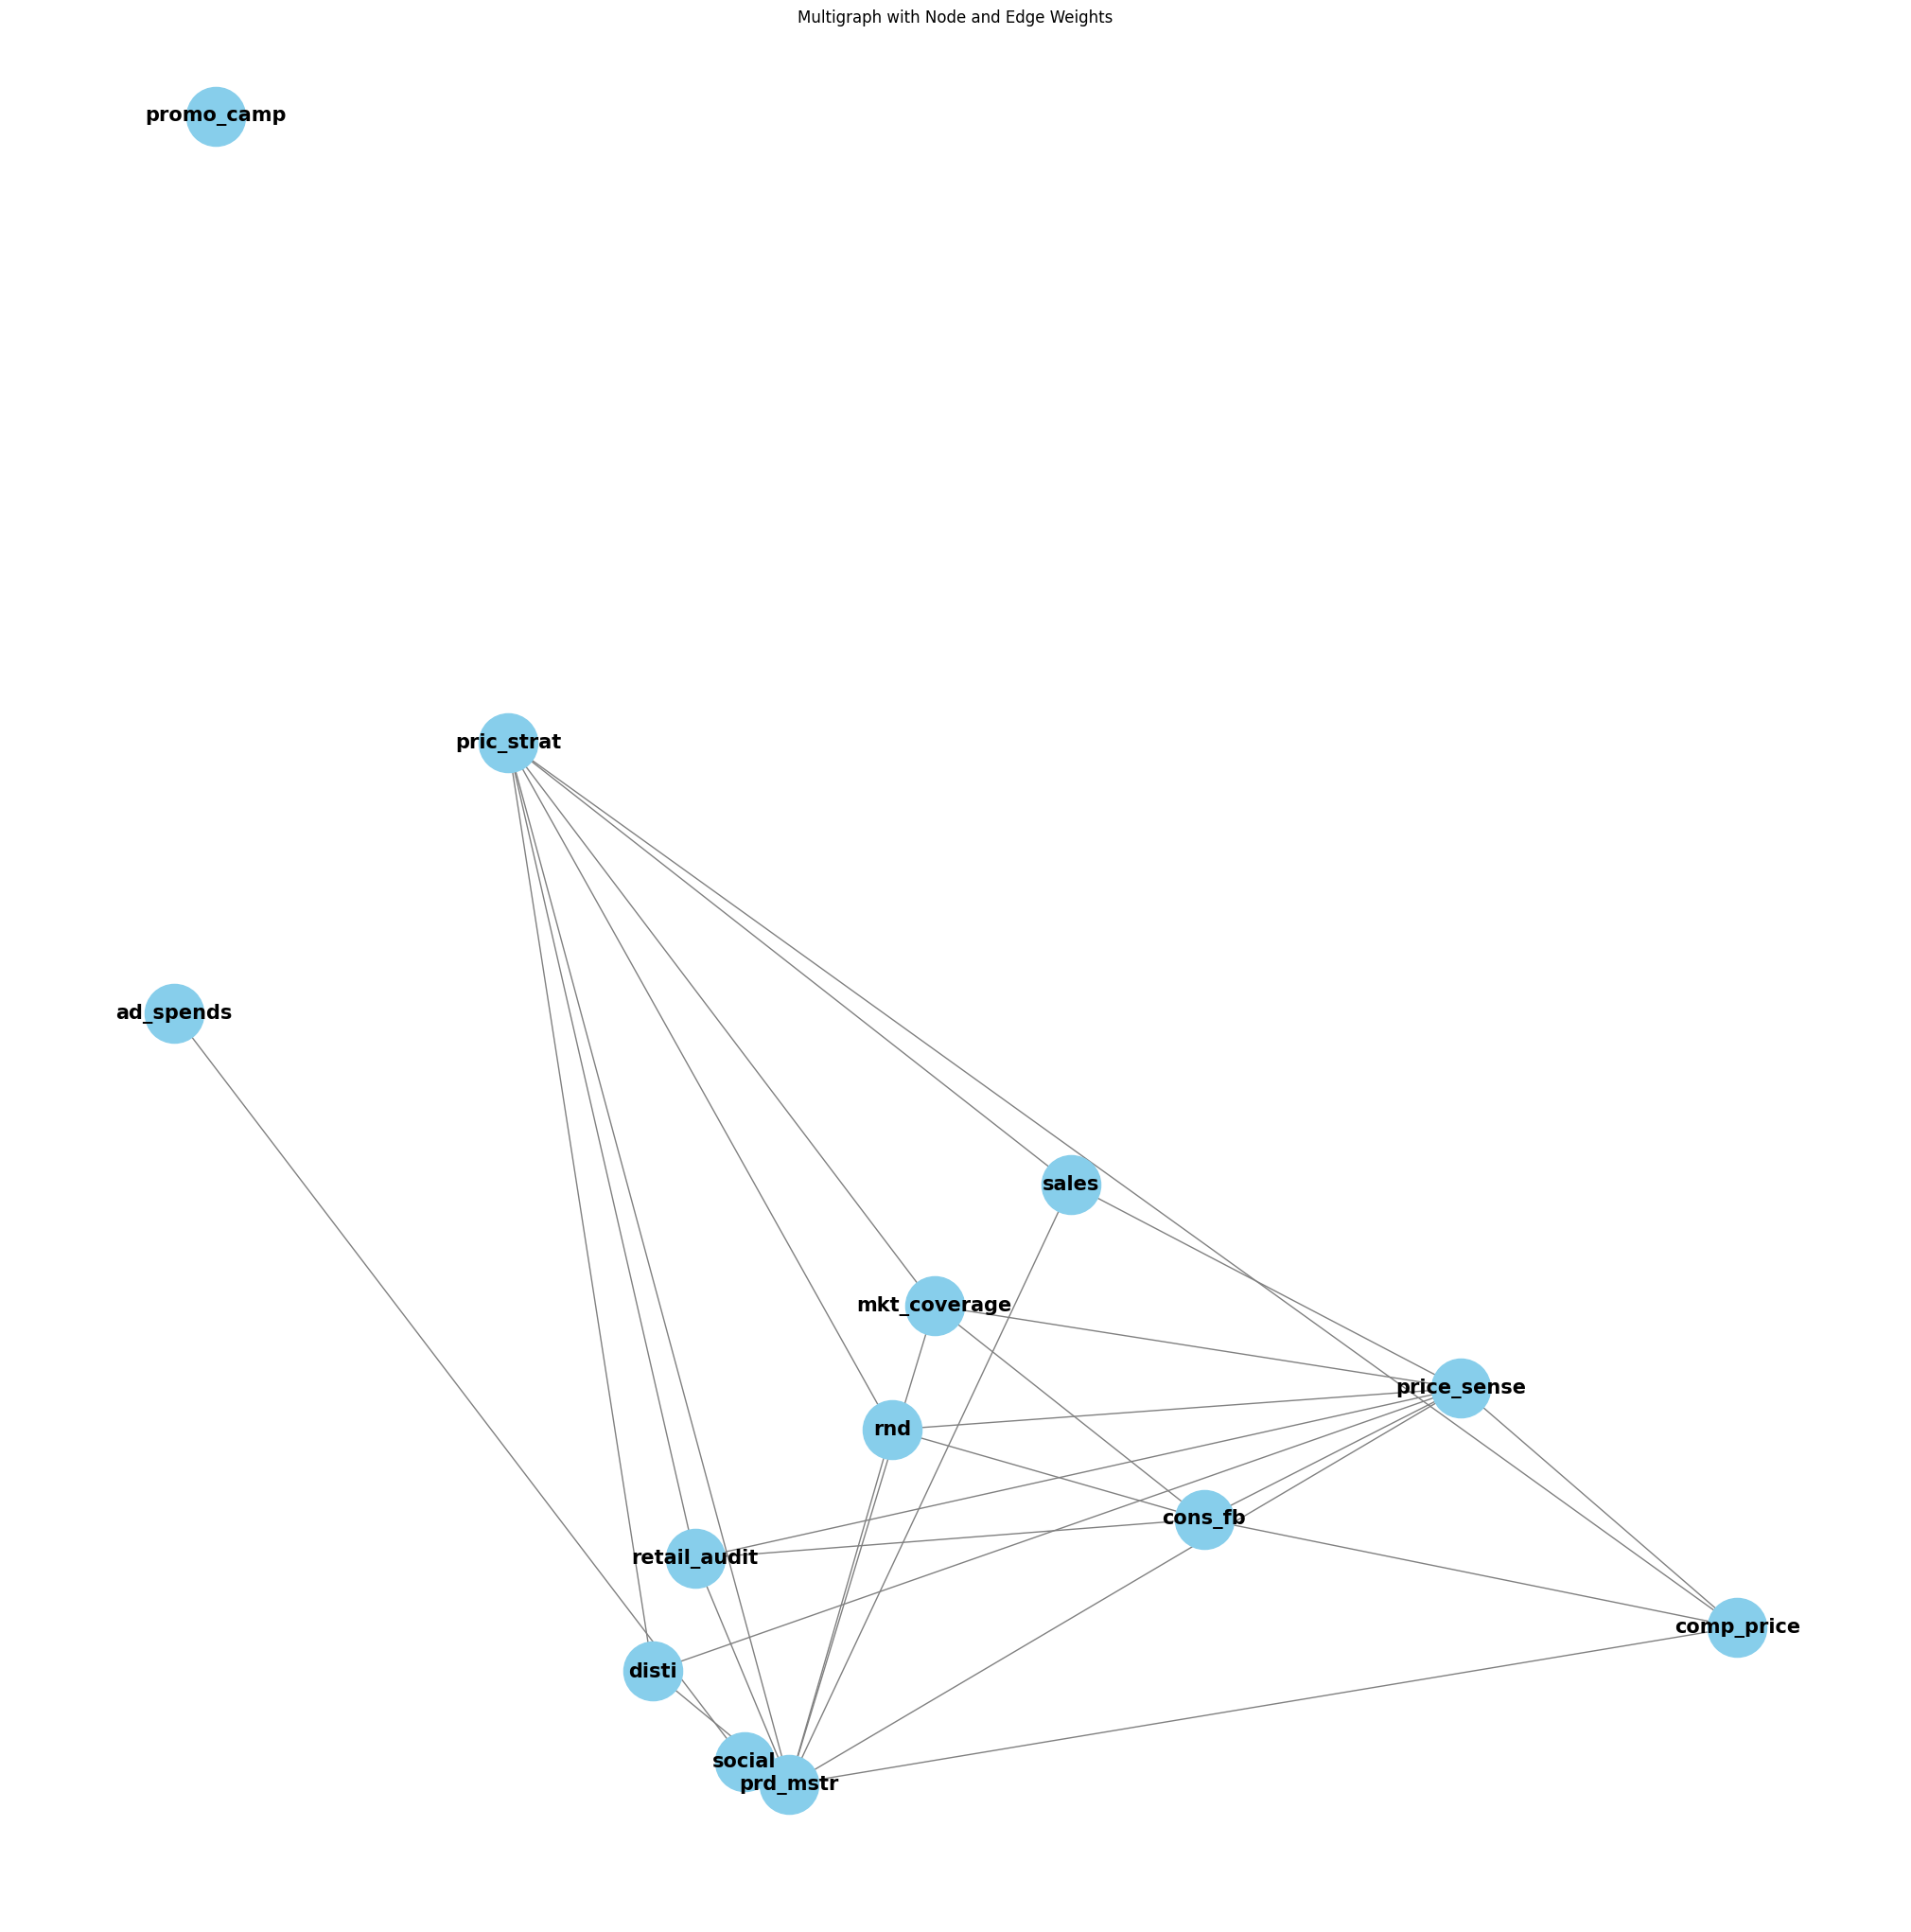

In [11]:
sm.visualize()  # To visualize the relationships as a graph


## Syncing with Snowflake Horizon Catalog


In [12]:
import os
import sqlglot
from snowflake.snowpark.session import Session
from snowflake.snowpark.exceptions import SnowparkSQLException

# Assuming the intugle library and its dependencies are installed in your Snowflake environment.
# You can add it to your environment via the 'Packages' menu.
# Required packages: intugle, sqlglot, pandas, pyyaml, etc.
from intugle.parser.manifest import ManifestLoader
from intugle.analysis.models import DataSet
from intugle.core.settings import settings
from snowflake.snowpark.context import get_active_session

session = get_active_session()

# Name for the internal stage to be created in Snowflake for file uploads
SNOWFLAKE_STAGE_NAME = "FMCG_RAW"
SNOWFLAKE_FILE_FORMAT_NAME = "intugle_csv_format"
SNOWFLAKE_CSV_STAGE_NAME = "SEMANTIC_LAYER_YAML"

# Set to True to skip the local CSV upload (PUT command).
# Use this if your files are already in the Snowflake stage specified above.
SKIP_CSV_UPLOAD = False


def load_intugle_manifest(project_path: str):
    """Loads the complete Intugle manifest from the specified project directory."""
    print(f"Loading Intugle manifest from: {project_path}")
    if not os.path.isdir(project_path):
        raise FileNotFoundError(
            f"The specified Intugle project path does not exist: {project_path}"
        )
    manifest_loader = ManifestLoader(project_path)
    manifest_loader.load()
    print("Manifest loaded successfully.")
    return manifest_loader.manifest


def map_intugle_to_snowflake_type(intugle_type: str) -> str:
    """Maps data types from Intugle's analysis to Snowflake SQL data types."""
    type_mapping = {
        "string": "VARCHAR",
        "integer": "NUMBER",
        "float": "FLOAT",
        "date & time": "TIMESTAMP_NTZ",
        "date": "DATE",
        "boolean": "BOOLEAN",
    }
    return type_mapping.get(intugle_type, "VARCHAR")


def create_and_populate_tables_snowpark(
    session: Session,
    manifest,
    db: str,
    schema: str,
):
    """
    Creates tables in Snowflake using Snowpark, stages local CSVs, and populates the tables.
    """
    print(f"Starting table creation in database '{db}', schema '{schema}'...")

    # Ensure the database and schema exist
    session.sql(f"USE DATABASE {db}").collect()
    session.sql(f"CREATE SCHEMA IF NOT EXISTS {schema}").collect()
    session.sql(f"USE SCHEMA {schema}").collect()

    # Create a stage and file format for CSV loading
    session.sql(f"CREATE STAGE IF NOT EXISTS {SNOWFLAKE_STAGE_NAME}").collect()
    session.sql(
        f"""
    CREATE OR REPLACE FILE FORMAT {SNOWFLAKE_FILE_FORMAT_NAME}
    TYPE = 'CSV'
    FIELD_OPTIONALLY_ENCLOSED_BY = '"'
    SKIP_HEADER = 1
    TRIM_SPACE = TRUE
    EMPTY_FIELD_AS_NULL = TRUE;
    """
    ).collect()

    for source in manifest.sources.values():
        table = source.table
        table_name = table.name
        full_table_name = f'"{db}"."{schema}"."{table_name}"'
        print(f"\nProcessing table: {full_table_name}")

        # --- 1. Generate CREATE TABLE Statement ---
        column_definitions = []
        cols_to_alter = []

        for col in table.columns:
            final_sf_type = map_intugle_to_snowflake_type(col.type)
            load_sf_type = "VARCHAR" if final_sf_type in ("TIMESTAMP_NTZ", "DATE") else final_sf_type
            if load_sf_type != final_sf_type:
                cols_to_alter.append((col.name, final_sf_type, col.description))
            not_null = " NOT NULL" if col.name == table.key else ""
            comment = f""" COMMENT '{col.description.replace("'", "''")}'""" if col.description else ""
            column_definitions.append(f'  "{col.name}" {load_sf_type}{not_null}{comment}')

        table_comment = f"""COMMENT = '{table.description.replace("'", "''")}'""" if table.description else ""
        create_ddl = f"""
        CREATE OR REPLACE TABLE {full_table_name} (
        {','.join(column_definitions)}
        )
        {table_comment};
        """
        print("Executing CREATE TABLE statement (with temp VARCHAR for dates)...")
        session.sql(create_ddl).collect()
        print(f"Table {full_table_name} created.")

        # --- 2. Stage and Load Data from CSV ---
        relative_path = table.details.get("path")
        if not relative_path:
            print(f"WARNING: No file path for table '{table_name}'. Skipping data load.")
            continue

        csv_filename_in_stage = os.path.basename(relative_path)

        if not SKIP_CSV_UPLOAD:
            local_csv_path = relative_path
            if not os.path.exists(local_csv_path):
                print(f"ERROR: CSV file not found at '{local_csv_path}'. Skipping.")
                continue
            print(f"Uploading {local_csv_path} to @{SNOWFLAKE_STAGE_NAME}...")
            session.file.put(local_csv_path, f"@{SNOWFLAKE_STAGE_NAME}", auto_compress=True, overwrite=True)
        else:
            print(f"Skipping CSV upload for {csv_filename_in_stage}. Assuming it exists in stage.")

        copy_command = f"""
        COPY INTO {full_table_name}
        FROM '@{SNOWFLAKE_STAGE_NAME}/{csv_filename_in_stage}.gz'
        FILE_FORMAT = (FORMAT_NAME = '{SNOWFLAKE_FILE_FORMAT_NAME}');
        """
        print(f"Loading data into {full_table_name} from stage...")
        session.sql(copy_command).collect()
        print("Successfully loaded raw data.")

        # --- 3. Alter Column Types using a robust Add, Update, Drop, Rename pattern ---
        if cols_to_alter:
            print("Altering date/timestamp columns to their final types...")
            for col_name, final_type, description in cols_to_alter:
                temp_col_name = f"{col_name}_TEMP_TYPE_CONV"
                try:
                    comment_clause = f""" COMMENT '{description.replace("'", "''")}'""" if description else ""
                    session.sql(f'ALTER TABLE {full_table_name} ADD COLUMN "{temp_col_name}" {final_type}{comment_clause}').collect()
                    cast_function = "TRY_TO_TIMESTAMP_NTZ" if final_type == "TIMESTAMP_NTZ" else "TRY_TO_DATE"
                    session.sql(f'UPDATE {full_table_name} SET "{temp_col_name}" = {cast_function}("{col_name}")').collect()
                    session.sql(f'ALTER TABLE {full_table_name} DROP COLUMN "{col_name}"').collect()
                    session.sql(f'ALTER TABLE {full_table_name} RENAME COLUMN "{temp_col_name}" TO "{col_name}"').collect()
                    print(f'  - Column "{col_name}" successfully converted to {final_type}.')
                except SnowparkSQLException as e:
                    print(f'  - WARNING: Could not convert column "{col_name}". Cleaning up. Reason: {e}')
                    session.sql(f'ALTER TABLE {full_table_name} DROP COLUMN IF EXISTS "{temp_col_name}"').collect()
        
        print(f"Successfully populated and configured table {full_table_name}.")


def apply_relationships_snowpark(session: Session, manifest, db: str, schema: str):
    """Applies primary and foreign key constraints in Snowflake using Snowpark."""
    if not manifest.relationships:
        print("\nNo relationships found. Skipping constraint application.")
        return

    print("\nApplying table relationships (Primary and Foreign Keys)...")
    session.sql(f"USE DATABASE {db}").collect()
    session.sql(f"USE SCHEMA {schema}").collect()

    for rel in manifest.relationships.values():
        pk_table = f'"{db}"."{schema}"."{rel.target.table}"'
        pk_column = f'"{rel.target.column}"'
        fk_table = f'"{db}"."{schema}"."{rel.source.table}"'
        fk_column = f'"{rel.source.column}"'

        try:
            print(f"Applying PRIMARY KEY on {pk_table}({pk_column})")
            session.sql(f"ALTER TABLE {pk_table} ADD PRIMARY KEY ({pk_column})").collect()
        except SnowparkSQLException as e:
            if "already exists" in str(e):
                print(f"Primary key on {pk_table} already exists.")
            else:
                print(f"WARNING: Could not apply PK to {pk_table}. Reason: {e}")

        try:
            print(f"Applying FOREIGN KEY from {fk_table} to {pk_table}")
            fk_ddl = f"ALTER TABLE {fk_table} ADD FOREIGN KEY ({fk_column}) REFERENCES {pk_table}({pk_column})"
            session.sql(fk_ddl).collect()
        except SnowparkSQLException as e:
            if "already exists" in str(e):
                print(f"Foreign key on {fk_table} already exists.")
            else:
                print(f"WARNING: Could not apply FK to {fk_table}. Reason: {e}")


def _standardize_tag_name(tag: str) -> str:
    """Converts a human-readable tag into a safe Snowflake identifier."""
    import re
    safe_name = re.sub(r'[^a-zA-Z0-9_]+', '_', tag)
    return safe_name.upper()


def apply_tags_snowpark(session: Session, manifest, db: str, schema: str):
    """Applies tags to tables and columns in Snowflake using Snowpark."""
    print("\nApplying tags to tables and columns...")
    session.sql(f"USE DATABASE {db}").collect()
    session.sql(f"USE SCHEMA {schema}").collect()

    tag_mapping = {}
    for source in manifest.sources.values():
        for tag in source.table.tags or []:
            if tag not in tag_mapping:
                tag_mapping[tag] = _standardize_tag_name(tag)
        for col in source.table.columns:
            for tag in col.tags or []:
                if tag not in tag_mapping:
                    tag_mapping[tag] = _standardize_tag_name(tag)

    for original_name, safe_name in tag_mapping.items():
        try:
            comment = original_name.replace("'", "''")
            session.sql(f"CREATE TAG IF NOT EXISTS {safe_name} COMMENT = '{comment}'").collect()
        except SnowparkSQLException as e:
            print(f"Warning: Could not create tag '{safe_name}'. Reason: {e}")

    for source in manifest.sources.values():
        table = source.table
        full_table_name = f'"{db}"."{schema}"."{table.name}"'
        if table.tags:
            for tag in table.tags:
                safe_name = tag_mapping.get(tag)
                if safe_name:
                    try:
                        session.sql(f'ALTER TABLE {full_table_name} SET TAG "{safe_name}" = \'true\'').collect()
                    except SnowparkSQLException as e:
                        print(f"WARNING: Could not apply tag '{safe_name}' to table {full_table_name}. Reason: {e}")
        for col in table.columns:
            if col.tags:
                for tag in col.tags:
                    safe_name = tag_mapping.get(tag)
                    if safe_name:
                        try:
                            session.sql(f'ALTER TABLE {full_table_name} MODIFY COLUMN "{col.name}" SET TAG "{safe_name}" = \'true\'').collect()
                        except SnowparkSQLException as e:
                            print(f"WARNING: Could not apply tag '{safe_name}' to column {col.name}. Reason: {e}")



def upload_folder_to_stage(session: Session, local_folder_path: str, stage_name: str):
    """
    Uploads all contents of a local folder to a specified Snowflake stage, preserving the subdirectory structure.
    The stage will be created or replaced.

    Args:
        session: The active Snowpark session.
        local_folder_path: The absolute path to the local folder to upload.
        stage_name: The name of the Snowflake stage to create/upload to.
    """
    print(f"\nUploading contents of folder '{local_folder_path}' to stage '@{stage_name}'...")

    if not os.path.isdir(local_folder_path):
        print(f"ERROR: Local folder not found at '{local_folder_path}'. Aborting upload.")
        return

    try:
        # Create (or replace) the stage to ensure it's clean
        session.sql(f"CREATE OR REPLACE STAGE {stage_name}").collect()
        print(f"Stage '@{stage_name}' created/re-created successfully.")

        # Walk through the local folder
        for root, _, files in os.walk(local_folder_path):
            for filename in files:
                local_file = os.path.join(root, filename)
                # Determine the relative path to preserve the folder structure in the stage
                relative_path = os.path.relpath(local_file, local_folder_path)
                # Snowflake paths use forward slashes
                stage_path = os.path.dirname(relative_path).replace("\\", "/")

                print(f"  - Uploading {local_file} to @{stage_name}/{stage_path}")
                session.file.put(local_file, f"@{stage_name}/{stage_path}", auto_compress=False, overwrite=True)

        print(f"Successfully uploaded all files from '{local_folder_path}' to stage '@{stage_name}'.")

    except Exception as e:
        print(f"ERROR: Failed to upload folder to stage. Reason: {e}")




def main(session: Session):
    """
    Main execution function to set up the Snowflake semantic layer from within a Snowpark Notebook.
    
    Args:
        session: The active Snowpark session, automatically provided in a Snowflake Notebook.
    """
    try:
        # 1. Load metadata from Intugle's YAML files
        manifest = load_intugle_manifest(settings.PROJECT_BASE)

        # 2. Create tables and populate them with data
        create_and_populate_tables_snowpark(
            session,
            manifest,
            SNOWFLAKE_DATABASE,
            SNOWFLAKE_SCHEMA,
        )

        # 3. Apply primary and foreign key constraints
        # apply_relationships_snowpark(session, manifest, SNOWFLAKE_DATABASE, SNOWFLAKE_SCHEMA)

        # 4. Apply tags to tables and columns
        apply_tags_snowpark(session, manifest, SNOWFLAKE_DATABASE, SNOWFLAKE_SCHEMA)

        # 5. Upload YAML files to Snowflake Stage
        upload_folder_to_stage(session, settings.PROJECT_BASE, SNOWFLAKE_CSV_STAGE_NAME)

        print("\n-------------------------------------------------")
        print("Snowflake setup process completed successfully!")
        print("-------------------------------------------------")

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()


main(session)


Connecting to Snowflake...
Connection successful.
Loading Intugle manifest from: /home/raphael/intugle/demo/snowflake_intugle/models
Manifest loaded successfully.
Starting table creation in database 'SNOWFLAKE_LEARNING_DB', schema 'FMCG'...

Processing table: "SNOWFLAKE_LEARNING_DB"."FMCG"."prd_mstr"
Executing CREATE TABLE statement (with temp VARCHAR for dates)...
Table "SNOWFLAKE_LEARNING_DB"."FMCG"."prd_mstr" created.
Uploading ./fmcg/prd_mstr.csv to @FMCG_RAW...
Loading data into "SNOWFLAKE_LEARNING_DB"."FMCG"."prd_mstr" from stage...
Successfully loaded raw data.
Successfully populated and configured table "SNOWFLAKE_LEARNING_DB"."FMCG"."prd_mstr".

Processing table: "SNOWFLAKE_LEARNING_DB"."FMCG"."retail_audit"
Executing CREATE TABLE statement (with temp VARCHAR for dates)...
Table "SNOWFLAKE_LEARNING_DB"."FMCG"."retail_audit" created.
Uploading ./fmcg/retail_audit.csv to @FMCG_RAW...
Loading data into "SNOWFLAKE_LEARNING_DB"."FMCG"."retail_audit" from stage...
Successfully loade

## 4. The Semantic Layer

The SemanticModel results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.

## 5. Data Product Creation

The semantic layer serves as a foundation for the DataProduct, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

#### EXAMPLE 1 : Pricing Strategy Impact: Economy Tier

In [18]:
data_product_config = \
{
  "name": "filtered_pricing_and_competition",
  "fields": [
    {"id": "prd_mstr.name", "name": "product_name"},
    {"id": "prd_mstr.category", "name": "product_category"},
    {"id": "pric_strat.strat_type", "name": "pricing_strategy"},
    {"id": "pric_strat.sales_chg", "name": "avg_sales_change_pct", "category": "measure", "measure_func": "average"},
    {"id": "comp_price.price_diff", "name": "avg_price_diff_vs_competitor", "category": "measure", "measure_func": "average"},
    {"id": "price_sense.demand_dec", "name": "avg_demand_decrease_on_price_inc", "category": "measure", "measure_func": "average"}
     ],
     "filter": {
       "selections": [
         {
           "id": "pric_strat.strat_type",
           "values": ["Economy Pricing"]
         }
       ],
       "sort_by": [
         {
           "id": "pric_strat.sales_chg",
           "alias": "avg_sales_change_pct",
           "direction": "desc"
         }
       ],
       "limit": 15
     }
   }


Now, let's use the `DataProduct` to generate the data product:

In [19]:
from intugle import DataProduct

# Create a DataProduct
dp = DataProduct() 

# Generate the data product
data_product = dp.build(data_product_config)

data_product.to_df()

Found existing YAML for 'prd_mstr'. Checking for staleness.
prd_mstr loaded
Found existing YAML for 'retail_audit'. Checking for staleness.
retail_audit loaded
Found existing YAML for 'mkt_coverage'. Checking for staleness.
mkt_coverage loaded
Found existing YAML for 'rnd'. Checking for staleness.
rnd loaded
Found existing YAML for 'sales'. Checking for staleness.
sales loaded
Found existing YAML for 'comp_price'. Checking for staleness.
comp_price loaded
Found existing YAML for 'pric_strat'. Checking for staleness.
pric_strat loaded
Found existing YAML for 'social'. Checking for staleness.
social loaded
Found existing YAML for 'promo_camp'. Checking for staleness.
promo_camp loaded
Found existing YAML for 'cons_fb'. Checking for staleness.
cons_fb loaded
Found existing YAML for 'ad_spends'. Checking for staleness.
ad_spends loaded
Found existing YAML for 'price_sense'. Checking for staleness.
price_sense loaded
Found existing YAML for 'disti'. Checking for staleness.
disti loaded
filt

,product_name,product_category,pricing_strategy,avg_sales_change_pct,avg_price_diff_vs_competitor,avg_demand_decrease_on_price_inc
0,Product 81,Personal Care,Economy Pricing,14.84,1.230,17.68
1,Product 22,Home Care,Economy Pricing,14.81,6.720,18.32
2,Product 35,Biscuits & Cookies,Economy Pricing,14.70,2.760,5.26
3,Product 51,Beverage,Economy Pricing,14.34,7.680,5.68
4,Product 86,Cakes,Economy Pricing,12.79,9.560,19.62
5,Product 59,Cakes,Economy Pricing,12.35,-12.910,21.06
6,Product 73,Beverage,Economy Pricing,12.04,8.760,16.20
7,Product 27,Personal Care,Economy Pricing,10.96,11.985,8.58
8,Product 56,Cakes,Economy Pricing,10.31,-8.970,14.79
9,Product 52,Personal Care,Economy Pricing,10.01,8.235,11.49


The `build` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:


In [20]:
# The generated SQL query
data_product.sql_query



'SELECT "prd_mstr"."name" as product_name, "prd_mstr"."category" as product_category, "pric_strat"."strat_type" as pricing_strategy, avg("pric_strat"."sales_chg") as avg_sales_change_pct, avg("comp_price"."price_diff") as avg_price_diff_vs_competitor, avg("price_sense"."demand_dec") as avg_demand_decrease_on_price_inc FROM price_sense LEFT JOIN prd_mstr ON "prd_mstr"."prd_id" = "price_sense"."pid" LEFT JOIN comp_price ON "comp_price"."pid" = "prd_mstr"."prd_id" LEFT JOIN pric_strat ON "comp_price"."pid" = "pric_strat"."prdid" WHERE ("pric_strat"."strat_type" IN (\'Economy Pricing\',)) GROUP BY "prd_mstr"."name" , "prd_mstr"."category" , "pric_strat"."strat_type" ORDER BY avg_sales_change_pct DESC LIMIT 15'

### Generating glossary for the Data Product

The `data_product` is in itself a DataSet object. Hence we can run generate glossaries for it as well. 

In [21]:

data_product.run(domain="Fast-Moving Consumer Goods")
data_product.profiling_df

/home/raphael/intugle/demo/snowflake_intugle/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/demo/snowflake_intugle/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] filtered_pricing_and_competition:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/demo/snowflake_intugle/.venv/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,product_name,filtered_pricing_and_competition,product_name,alphanumeric,L2OutputTypes.dimension,Identifies the name used to distinguish indivi...,"[Product Identification, Competitive Analysis,...",15,0,15,1.000000,1.0,"[Product 81, Product 52, Product 51, Product 5..."
1,product_category,filtered_pricing_and_competition,product_category,close_ended_text,L2OutputTypes.dimension,Groups products into predefined classification...,"[Product Classification, Category Insights, Ma...",15,0,5,0.333333,1.0,"[Personal Care, Cakes, Beverage, Home Care, Bi..."
2,pricing_strategy,filtered_pricing_and_competition,pricing_strategy,close_ended_text,L2OutputTypes.dimension,Defines the approach used to set product price...,"[Pricing Model, Market Strategy, Cost Optimiza...",15,0,1,0.066667,1.0,[Economy Pricing]
3,avg_sales_change_pct,filtered_pricing_and_competition,avg_sales_change_pct,float,L2OutputTypes.measure,Measures the average percentage change in sale...,"[Sales Performance Analysis, Percentage Change...",15,0,15,1.000000,1.0,"[8.05, 10.96, 10.31, 10.01, 7.9, 14.84, 12.04,..."
4,avg_price_diff_vs_competitor,filtered_pricing_and_competition,avg_price_diff_vs_competitor,float,L2OutputTypes.measure,Indicates the average price difference of a pr...,"[Competitive Pricing Analysis, Market Position...",15,0,15,1.000000,1.0,"[10.48, 4.994999999999999, 11.985, 6.72, 8.76,..."


## Syncing the data product with Snowflake Catalog

A data product can be passed in the `create_dp_table_in_snowflake` function along with the target catalog and schema to store it in the Unity Catalog

In [22]:
import sqlglot
from intugle.analysis.models import DataSet
from snowflake.snowpark.context import get_active_session

session = get_active_session()


def create_dp_in_snowflake(
    data_product: DataSet,
    db: str,
    schema: str,
    table_name: str,
):
    """Executes a data product's query and saves it as a new table in Snowflake using Snowpark."""
    print(f"\nAttempting to create data product table: {table_name}")
    session.sql(f"USE DATABASE {db}").collect()
    session.sql(f"CREATE SCHEMA IF NOT EXISTS {schema}").collect()
    session.sql(f"USE SCHEMA {schema}").collect()
    full_table_name = f'"{db}"."{schema}"."{table_name}"'

    duckdb_query = data_product.sql_query
    if not duckdb_query:
        print("ERROR: Data product does not contain a SQL query.")
        return

    try:
        expression = sqlglot.parse_one(duckdb_query, read="duckdb")
        snowflake_sql = expression.sql(dialect="snowflake", pretty=True, identify=True)
        print("Successfully translated SQL query for Snowflake (with quoted identifiers):")
        print(snowflake_sql)
    except Exception as e:
        print(f"ERROR: Failed to transpile SQL query using sqlglot. Reason: {e}")
        return

    try:
        print(f"Executing CREATE TABLE AS SELECT for {full_table_name}...")
        session.sql(f"CREATE OR REPLACE TABLE {full_table_name} AS\n{snowflake_sql}").collect()
        print("Table created successfully.")

        # --- Apply all metadata (Comments and Tags) ---
        print("Applying metadata to new data product table...")

        # 1. Collect, standardize, and create all necessary tags
        tag_mapping = {}
        for tag in data_product.source_table_model.tags or []:
            if tag not in tag_mapping:
                tag_mapping[tag] = _standardize_tag_name(tag)
        for col in data_product.source_table_model.columns:
            for tag in col.tags or []:
                if tag not in tag_mapping:
                    tag_mapping[tag] = _standardize_tag_name(tag)

        for original_name, safe_name in tag_mapping.items():
            try:
                comment = original_name.replace("'", "''")
                session.sql(f"CREATE TAG IF NOT EXISTS {safe_name} COMMENT = '{comment}'").collect()
            except SnowparkSQLException as e:
                print(f"Warning: Could not create tag '{safe_name}'. Reason: {e}")

        # 2. Apply table comment
        if data_product.source_table_model.description:
            comment = data_product.source_table_model.description.replace("'", "''")
            session.sql(f"COMMENT ON TABLE {full_table_name} IS '{comment}'").collect()
            print("  - Applied table comment.")

        # 3. Apply table tags
        if data_product.source_table_model.tags:
            for tag in data_product.source_table_model.tags:
                safe_name = tag_mapping.get(tag)
                if safe_name:
                    try:
                        session.sql(f'ALTER TABLE {full_table_name} SET TAG "{safe_name}" = \'true\'').collect()
                    except SnowparkSQLException as e:
                        print(f"  - WARNING: Could not apply tag '{safe_name}' to table {full_table_name}. Reason: {e}")
            print("  - Applied table tags.")

        # 4. Apply column comments and tags
        for col in data_product.source_table_model.columns:
            # Apply column comment
            if col.description:
                col_comment = col.description.replace("'", "''")
                try:
                    session.sql(f'ALTER TABLE {full_table_name} MODIFY COLUMN "{col.name}" COMMENT \'{col_comment}\'').collect()
                except SnowparkSQLException as e:
                    print(f'  - WARNING: Could not apply comment to column "{col.name}". Reason: {e}')

            # Apply column tags
            if col.tags:
                for tag in col.tags:
                    safe_name = tag_mapping.get(tag)
                    if safe_name:
                        try:
                            session.sql(f'ALTER TABLE {full_table_name} MODIFY COLUMN "{col.name}" SET TAG "{safe_name}" = \'true\'').collect()
                        except SnowparkSQLException as e:
                            print(f'  - WARNING: Could not apply tag "{safe_name}" to column "{col.name}". Reason: {e}')
        print("  - Applied all column comments and tags.")
        
        print(f"\nData product '{table_name}' successfully created and documented in Snowflake.")

    except Exception as e:
        print(f"ERROR: Failed to create or document data product table '{full_table_name}'. Reason: {e}")
    

Now you can call the `create_dp_table_in_databricks` to create the data product in the unity catalog. 

In [23]:
# Define where to save it in Unity Catalog
db = SNOWFLAKE_DATABASE
schema = SNOWFLAKE_SCHEMA
   
# 3. Call the new function to create it in Databricks
create_dp_in_snowflake(data_product, db, schema, "competitor_pricing_by_product")

Connecting to Snowflake...
Connection successful.

Attempting to create data product table: competitor_pricing_by_product
Successfully translated SQL query for Snowflake (with quoted identifiers):
SELECT
  "prd_mstr"."name" AS "product_name",
  "prd_mstr"."category" AS "product_category",
  "pric_strat"."strat_type" AS "pricing_strategy",
  AVG("pric_strat"."sales_chg") AS "avg_sales_change_pct",
  AVG("comp_price"."price_diff") AS "avg_price_diff_vs_competitor",
  AVG("price_sense"."demand_dec") AS "avg_demand_decrease_on_price_inc"
FROM "price_sense"
LEFT JOIN "prd_mstr"
  ON "prd_mstr"."prd_id" = "price_sense"."pid"
LEFT JOIN "comp_price"
  ON "comp_price"."pid" = "prd_mstr"."prd_id"
LEFT JOIN "pric_strat"
  ON "comp_price"."pid" = "pric_strat"."prdid"
WHERE
  (
    "pric_strat"."strat_type" IN ('Economy Pricing')
  )
GROUP BY
  "prd_mstr"."name",
  "prd_mstr"."category",
  "pric_strat"."strat_type"
ORDER BY
  "avg_sales_change_pct" DESC NULLS LAST
LIMIT 15
Executing CREATE TABLE AS

## Conclusion

You've learned how to:

*   Configure your LLM provider and Embeddings provider.
*   Build a semantic model using the `SemanticModel`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Sync the semantic model with Snowflake Catalog
*   Perform semantic search on your semantic model.
*   Generate data products from the semantic layer using the `DataProduct`.
*   Sync the `DataProduct` to Snowflake

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.